<div align="center">
  
# OASIS ANALYTICS
    
</div>

# Breast Cancer Prediction

## Business Understanding

PRIMO Cancer Research Institute (PCRI) is a non-profit organization dedicated to studying and understanding the biology of cancer, developing new treatments and therapies, and improving the lives of those affected by the disease.

They currently have three techniques to detect Breast Cancer:
* Mammography (63% to 97% correctness) 
* FNA (Fine Needle Aspiration) with visual interpretation (65% to 98% correctness)
* Surgical biopsy (approximately 100% correctness). 

Mammography and FNA with visual interpretation correctness varies widely, and the surgical biopsy, although reliable, is invasive and costly.

Due to the nature of their research, they need improve the accuracy of cancer diagnosis and prognosis, and ultimately develop more effective treatments for patients. Hence, they need a machine learning model that can make very accurate predictions on whether the diagnosis of breast tissues are benign or malignant and ultimately develop more effective treatments for patients.

The expectations for this project are:
* Create meaningful insights and visuals using the FNA dataset.
* Develop a ML model with high accuracy and precision.

## The dataset

https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data

The Breast Cancer (Wisconsin) Diagnosis dataset contains the diagnosis and a set of 30 features describing the characteristics of the cell nuclei present in the digitized image of a fine needle aspirate __(FNA)__ of a breast mass.

Ten real-valued features are computed for each cell nucleus:

- radius (mean of distances from center to points on the perimeter);
- texture (standard deviation of gray-scale values);
- perimeter;
- area;
- smoothness (local variation in radius lengths);
- compactness (perimeter^2 / area - 1.0);
- concavity (severity of concave portions of the contour);
- concave points (number of concave portions of the contour);
- symmetry;
- fractal dimension (“coastline approximation” - 1).<br>

<font color=blue> __The mean, standard error (SE) and “worst” or largest__ (mean of the three largest values) of these features were computed for each image, resulting in 30 features. We will analyze the features to understand the predictive value for diagnosis. We will then create models using two different algorithms and use the models to predict the diagnosis.</font>

## Fine needle aspiration (FNA)
FNA is a diagnostic procedure used to investigate lumps or masses. In this technique, a thin (23–25 gauge), hollow needle is inserted into the mass for sampling of cells that, after being stained, will be examined under a microscope (biopsy). Fine-needle aspiration biopsies are very safe minor surgical procedures.

### Connect to MySQL Data Bucket

In [1]:
import mysql.connector
import warnings

warnings.filterwarnings("ignore")

conn_str = {
    "host": "sql7.freesqldatabase.com",
    "user": "sql7588621",
    "password": "LZVDDRKVYi",
    "database": "sql7588621",
}

cnxn = mysql.connector.connect(**conn_str)

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', None)
%matplotlib inline

# Import and Explore Data

In [3]:
#read data

df = pd.read_sql("SELECT * FROM sql7588621.Cancer", cnxn)
cnxn.close()

In [4]:
df.sample(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
388,903011,B,11.270,15.50,73.38,392.0,0.08365,0.11140,0.10070,0.02757,0.1810,0.07252,0.3305,1.0670,2.569,22.970,0.010380,0.066690,0.09472,0.020470,0.01219,0.012330,12.04,18.93,79.73,450.0,0.11020,0.28090,0.30210,0.08272,0.2157,0.10430
440,909411,B,10.970,17.20,71.73,371.5,0.08915,0.11130,0.09457,0.03613,0.1489,0.06640,0.2574,1.3760,2.806,18.150,0.008565,0.046380,0.06430,0.017680,0.01516,0.004976,12.36,26.87,90.14,476.4,0.13910,0.40820,0.47790,0.15550,0.2540,0.09532
321,894618,M,20.160,19.66,131.10,1274.0,0.08020,0.08564,0.11550,0.07726,0.1928,0.05096,0.5925,0.6863,3.868,74.850,0.004536,0.013760,0.02645,0.012470,0.02193,0.001589,23.06,23.03,150.20,1657.0,0.10540,0.15370,0.26060,0.14250,0.3055,0.05933
101,862722,B,6.981,13.43,43.79,143.5,0.11700,0.07568,0.00000,0.00000,0.1930,0.07818,0.2241,1.5080,1.553,9.833,0.010190,0.010840,0.00000,0.000000,0.02659,0.004100,7.93,19.54,50.41,185.2,0.15840,0.12020,0.00000,0.00000,0.2932,0.09382
279,8911834,B,13.850,15.18,88.99,587.4,0.09516,0.07688,0.04479,0.03711,0.2110,0.05853,0.2479,0.9195,1.830,19.410,0.004235,0.015410,0.01457,0.010430,0.01528,0.001593,14.98,21.74,98.37,670.0,0.11850,0.17240,0.14560,0.09993,0.2955,0.06912
415,905686,B,11.890,21.17,76.39,433.8,0.09773,0.08120,0.02555,0.02179,0.2019,0.06290,0.2747,1.2030,1.930,19.530,0.009895,0.030530,0.01630,0.009276,0.02258,0.002272,13.05,27.21,85.09,522.9,0.14260,0.21870,0.11640,0.08263,0.3075,0.07351
263,889403,M,15.610,19.38,100.00,758.6,0.07840,0.05616,0.04209,0.02847,0.1547,0.05443,0.2298,0.9988,1.534,22.180,0.002826,0.009105,0.01311,0.005174,0.01013,0.001345,17.91,31.67,115.90,988.6,0.10840,0.18070,0.22600,0.08568,0.2683,0.06829
109,864018,B,11.340,21.26,72.48,396.5,0.08759,0.06575,0.05133,0.01899,0.1487,0.06529,0.2344,0.9861,1.597,16.410,0.009113,0.015570,0.02443,0.006435,0.01568,0.002477,13.01,29.15,83.99,518.1,0.16990,0.21960,0.31200,0.08278,0.2829,0.08832
210,881046502,M,20.580,22.14,134.70,1290.0,0.09090,0.13480,0.16400,0.09561,0.1765,0.05024,0.8601,1.4800,7.029,111.700,0.008124,0.036110,0.05489,0.027650,0.03176,0.002365,23.24,27.84,158.30,1656.0,0.11780,0.29200,0.38610,0.19200,0.2909,0.05865
443,909777,B,10.570,18.32,66.82,340.9,0.08142,0.04462,0.01993,0.01111,0.2372,0.05768,0.1818,2.5420,1.277,13.120,0.010720,0.013310,0.01993,0.011110,0.01717,0.004492,10.94,23.31,69.35,366.3,0.09794,0.06542,0.03986,0.02222,0.2699,0.06736


In [5]:
# check shape of data

df.shape

(569, 32)

In [6]:
#check information about the DataFrame

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [7]:
#check data columns

df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [8]:
#check for null values

df.isnull().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave_points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave_points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave_points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

There are no null values in the dataset

In [9]:
#check for duplicates

df.duplicated().sum()

0

There are no duplicates in the dataset

In [10]:
#drop id column

df.drop("id", axis=1, inplace=True)

In [11]:
#check summary statistics for dataframe

df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


# Exploratory Data Analysis (EDA)

## Count Plot of Target (Diagnosis) Column 

Benign Patient Count: 357
Malignant Patient Count: 212


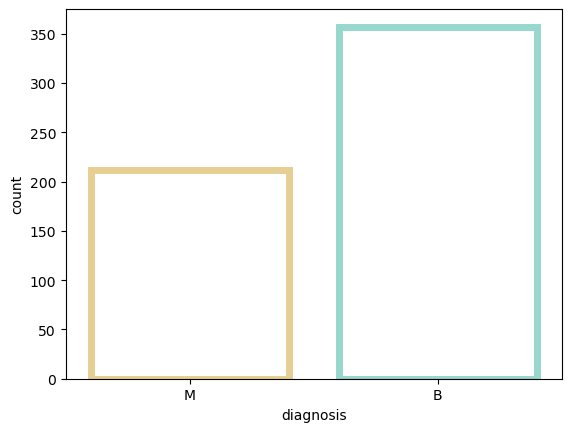

In [12]:
#countplot of patient diagnosis

sns.countplot(
    x="diagnosis",
    facecolor=(0, 0, 0, 0),
    linewidth=5,
    edgecolor=sns.color_palette("BrBG", 2),
    data=df,
)

print(
    "Benign Patient Count: {}".format(df[
        df["diagnosis"] == "B"]["diagnosis"].count())
)
print(
    "Malignant Patient Count: {}".format(
        df[df["diagnosis"] == "M"]["diagnosis"].count()
    )
);

## Donut Chart of Target Column

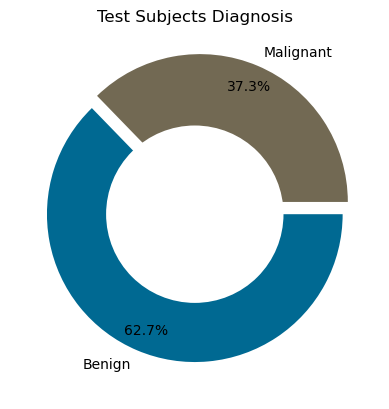

In [13]:
#item labels for donutchart
diagdiag = ["Malignant", "Benign"]

#setting size in chart based on
Diagnosis = [
    df[df["diagnosis"] == "M"]["diagnosis"].count(),
    df[df["diagnosis"] == "B"]["diagnosis"].count(),
]

#colors
colors = ["#726953", "#006992"]

#explosion
explode = (0.09, 0.00)

#pie chart
plt.pie(
    Diagnosis,
    colors=colors,
    labels=diagdiag,
    autopct="%1.1f%%",
    pctdistance=0.85,
    explode=explode,
)

#insert circle in chart
centre_circle = plt.Circle((0, 0), 0.60, fc="white")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

#add title of chart
plt.title("Test Subjects Diagnosis");

The target variable daignosis is split into Benign (B) and Malignant (M) with benign having 357 (62.7%) records and malignant 212 (37.3%) records.

## Distribution of Features

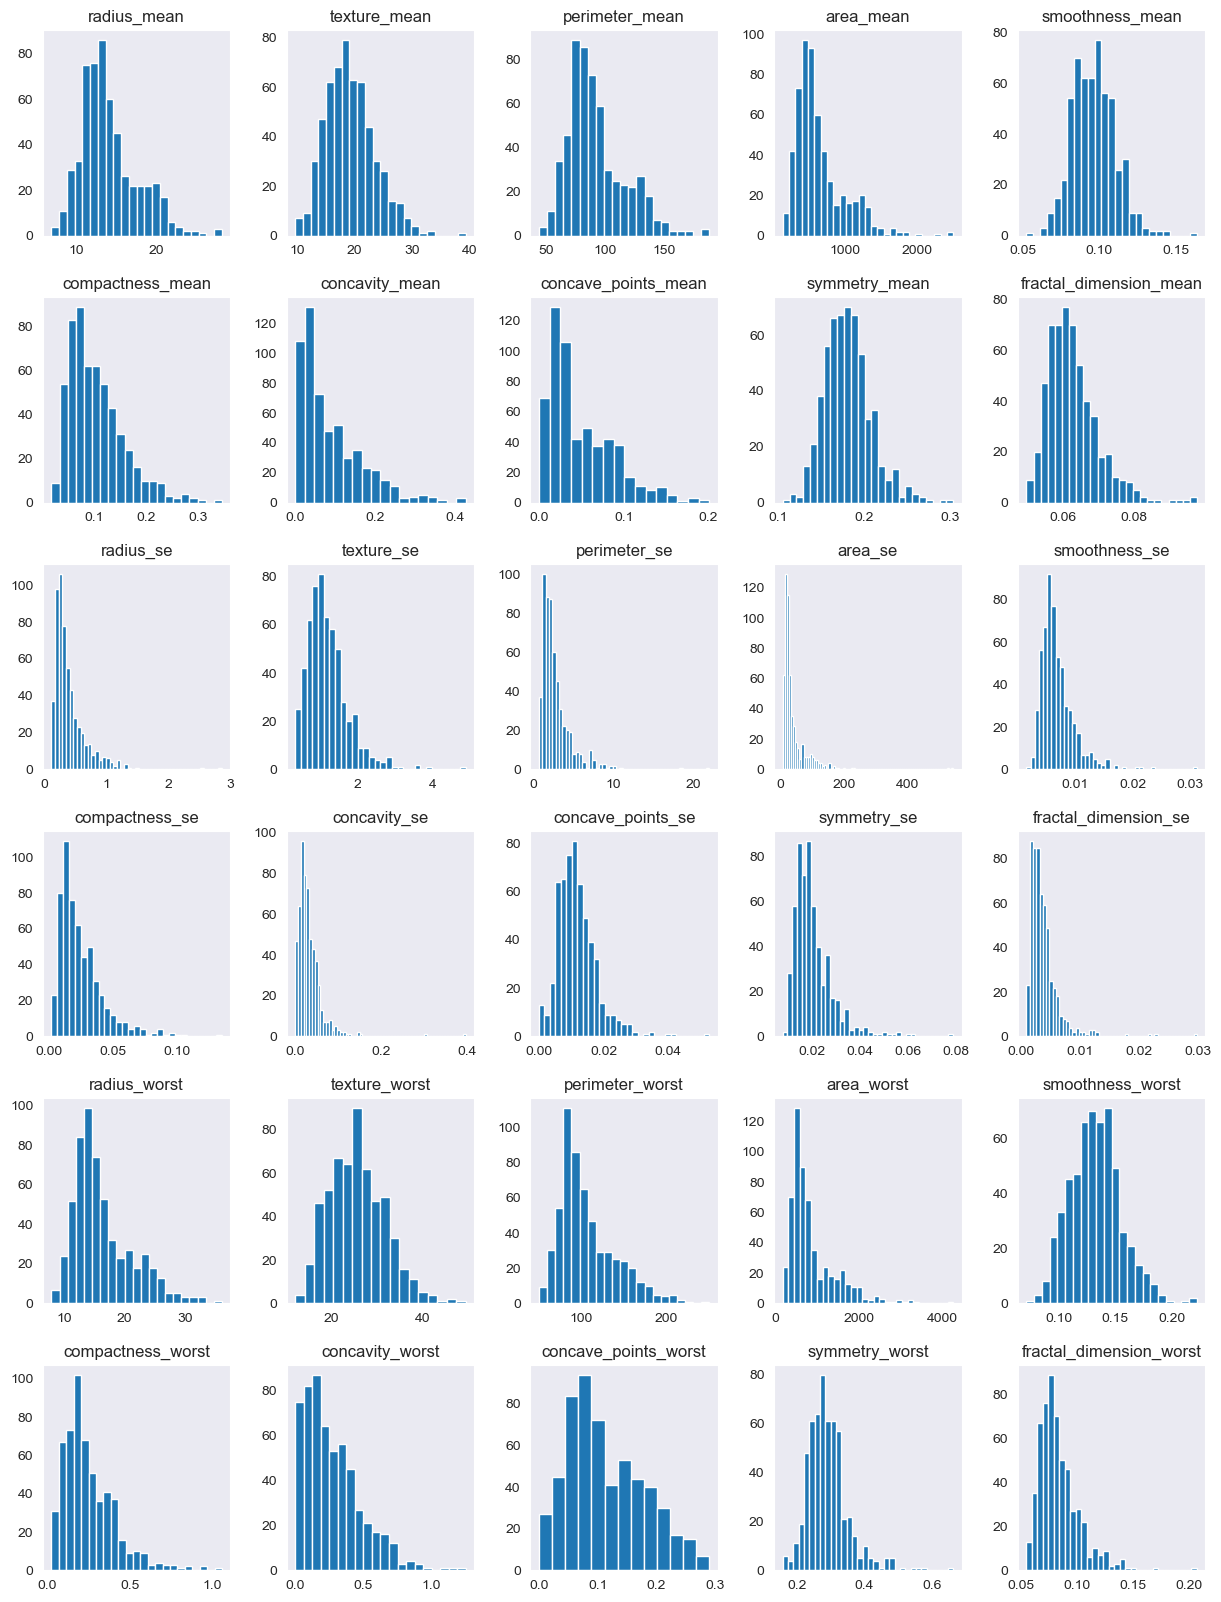

In [14]:
#distribution plot

sns.set_style("darkgrid")
df.hist(figsize=(15, 20), grid=False, bins="auto");

Most of the features are skewed to the right, indicating that most of the values are at the lower end of the spectrum. 

## Correlation of Features

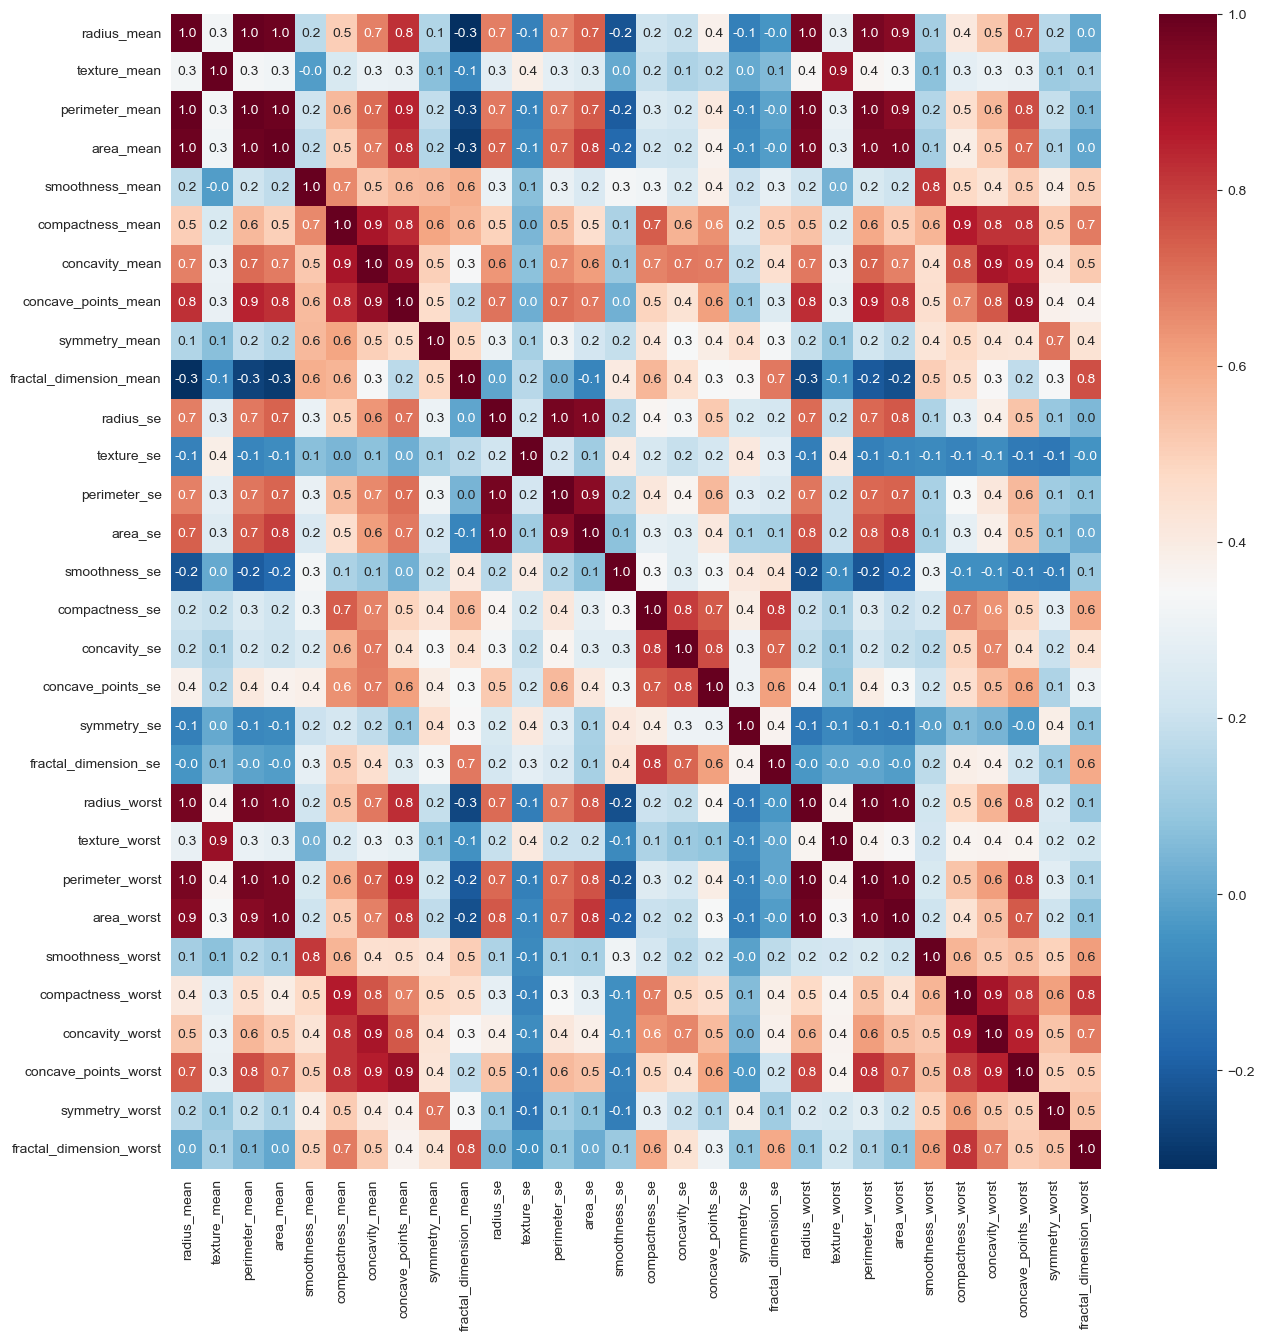

In [15]:
#plot heatmap

f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr(), cmap="RdBu_r", fmt= ".1f" ,ax=ax, annot=True);

### Correlation Classification by mean

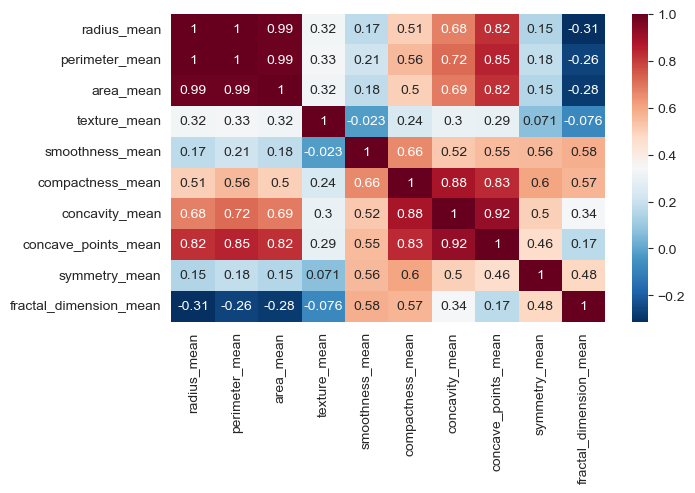

In [16]:
corr_mean = df[['radius_mean','perimeter_mean','area_mean','texture_mean','smoothness_mean','compactness_mean',
                'concavity_mean','concave_points_mean','symmetry_mean','fractal_dimension_mean']]
plt.figure(figsize=(7,4))
sns.heatmap(corr_mean.corr(),annot=True,cmap='RdBu_r');

<font color=blue>
The radius, perimeter, area, concavity, and concavity of the dataset have a significant degree of correlation with one another suggesting multicollinearity

## Pairplot of Features

## Characterisation by field groupings
Involves grouping the attributes in order to find similarities between fields of the same class;

In [17]:
df_selection_mean1 = df[["diagnosis", "radius_mean", "perimeter_mean", "area_mean", "compactness_mean"]]
df_selection_mean2 = df[["diagnosis", "texture_mean", "smoothness_mean","symmetry_mean","fractal_dimension_mean"]]
df_selection_mean3 = df[["diagnosis", "concavity_mean", "concave_points_mean"]]

#### Mean of the Radius, Perimeter, Area, Compactness

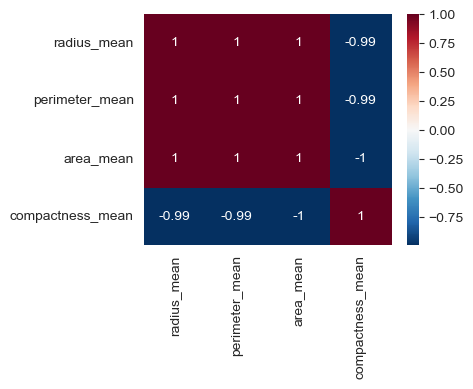

In [18]:
#showing the correlation between radius_mean, perimeter_mean, area_mean, compactness_mean
RPA_mean = df[["diagnosis", "radius_mean", "perimeter_mean", "area_mean","compactness_mean"]].corr()
plt.figure(figsize=(4,3))
sns.heatmap(RPA_mean.corr(),annot=True,cmap='RdBu_r');

<font color=blue> An extremely high degree of correlation exists between the mean of the radius, perimeter, area, and compactness of the dataset and so will trend in the same direction for both benign and malignant cells

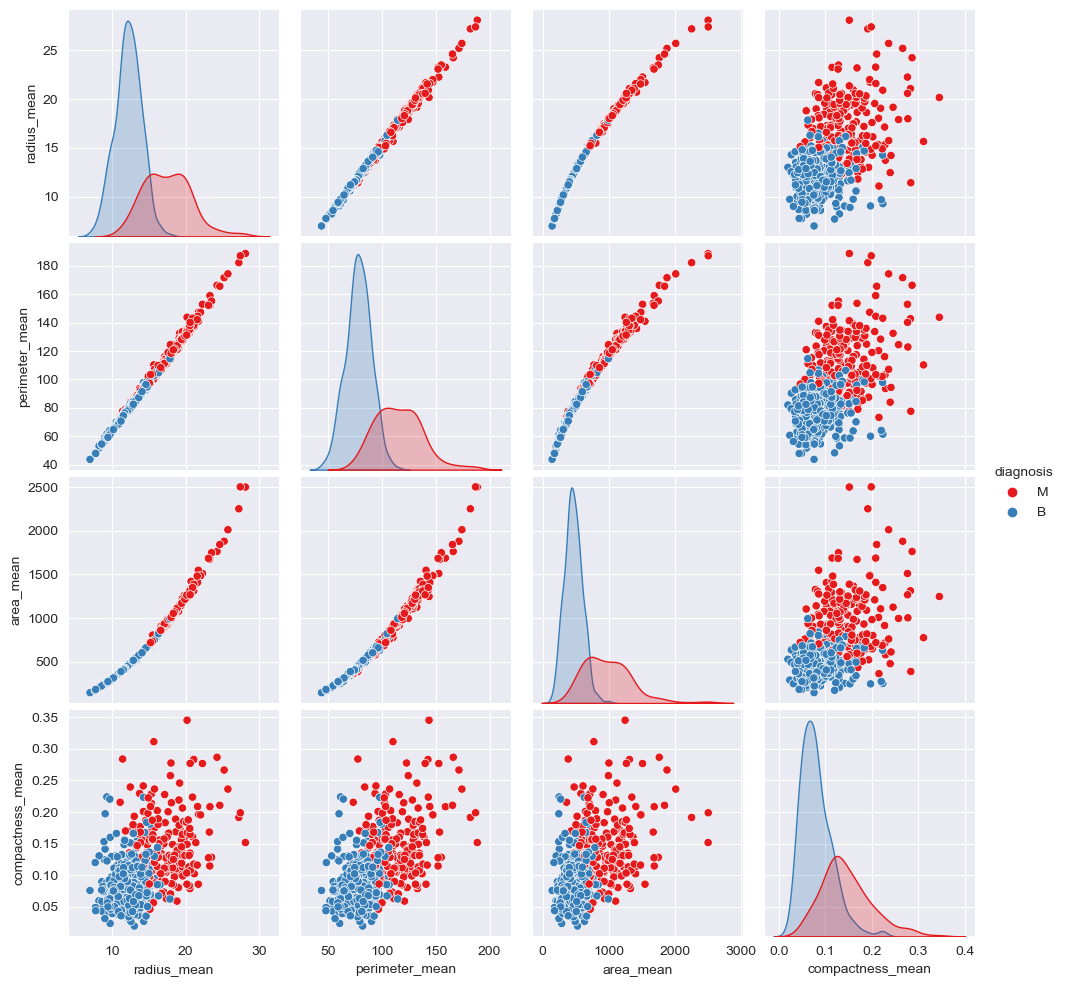

In [19]:
sns.pairplot(df_selection_mean1, hue="diagnosis", palette="Set1");

In [22]:
#reversing the row and column axis
RPAC_minmax = RPAC_minmax.transpose()
RPAC_minmax

,min,max
radius_mean,6.98100,28.1100
perimeter_mean,43.79000,188.5000
area_mean,143.50000,2501.0000
compactness_mean,0.01938,0.3454


In [20]:
#getting the min and max values of radius_mean, perimeter_mean, area_mean, and compactness_mean
RPAC_min = df[['radius_mean','perimeter_mean','area_mean','compactness_mean']].min()
RPAC_max = df[['radius_mean','perimeter_mean','area_mean','compactness_mean']].max()

#putting the min and max values in a dataframe
RPAC_minmax = pd.DataFrame([RPAC_min,RPAC_max])
RPAC_minmax

,radius_mean,perimeter_mean,area_mean,compactness_mean
0,6.981,43.79,143.5,0.01938
1,28.110,188.50,2501.0,0.34540


In [21]:
#replacing the indexes 0 and 1 with min and max
RPAC_minmax.rename({0:'min',1:'max'}, axis=0, inplace=True)
RPAC_minmax

,radius_mean,perimeter_mean,area_mean,compactness_mean
min,6.981,43.79,143.5,0.01938
max,28.110,188.50,2501.0,0.34540


<font color=blue> This pair plot reveals that benign cells or `["B"]` generally have smaller radii, perimeter, area, and compactness than malignant cells of comparative values. A few outliers exists (that do not necesarily distort the conformation of the plots), these are accounted for by "Worst" values. 

#### Mean of the texture, smoothness, symmetry, fractal_dimension of the dataset

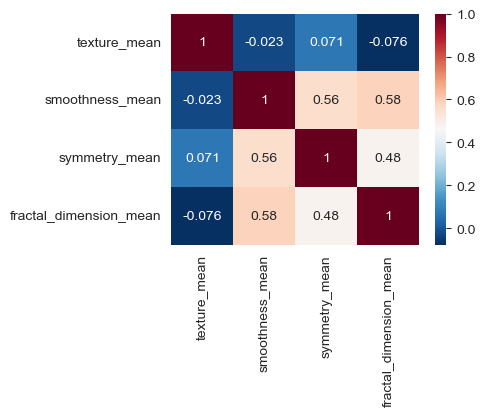

In [23]:
#showing the correlation between the texture_mean, smoothness_mean, symmetry_mean, and fractal_dimension_mean
TSC_mean = df[["texture_mean", "smoothness_mean","symmetry_mean","fractal_dimension_mean"]]
plt.figure(figsize=(4,3))
sns.heatmap(TSC_mean.corr(),annot=True,cmap='RdBu_r'); 

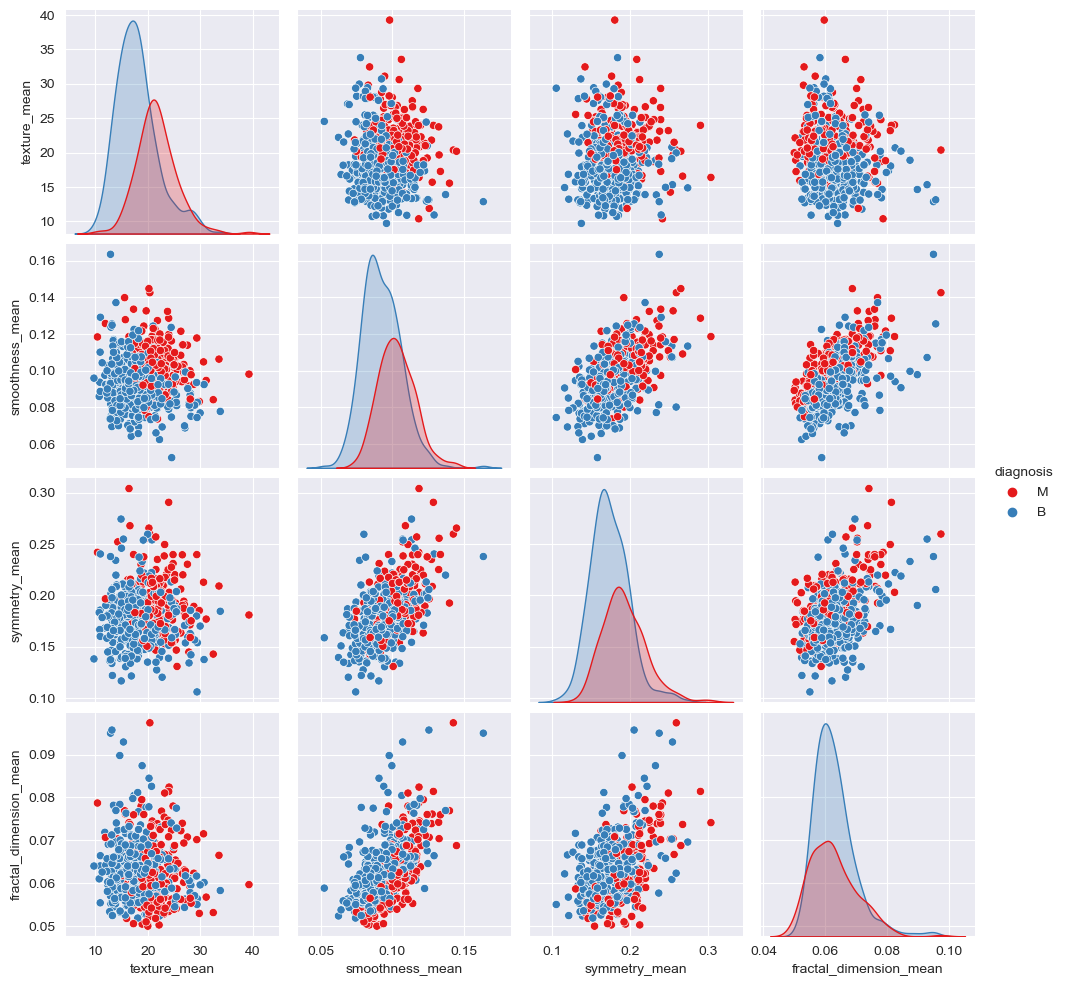

In [24]:
sns.pairplot(df_selection_mean2, hue="diagnosis", palette="Set1");

In [25]:
#getting the min and max values of radius_mean, perimeter_mean, area_mean, and compactness_mean
TSSF_min=df[['texture_mean','smoothness_mean','symmetry_mean','fractal_dimension_mean']].min()
TSSF_max=df[['texture_mean','smoothness_mean','symmetry_mean','fractal_dimension_mean']].max()

#putting the min and max values in a dataframe
TSSF_minmax =pd.DataFrame([TSSF_min,TSSF_max])
TSSF_minmax

,texture_mean,smoothness_mean,symmetry_mean,fractal_dimension_mean
0,9.71,0.05263,0.106,0.04996
1,39.28,0.16340,0.304,0.09744


In [26]:
#replacing the indexes 0 and 1 with min and max
TSSF_minmax.rename({0:'min',1:'max'}, axis=0, inplace=True)
TSSF_minmax

,texture_mean,smoothness_mean,symmetry_mean,fractal_dimension_mean
min,9.71,0.05263,0.106,0.04996
max,39.28,0.16340,0.304,0.09744


In [27]:
#reversing the row and column axis
TSSF_minmax = TSSF_minmax.transpose()
TSSF_minmax

,min,max
texture_mean,9.71000,39.28000
smoothness_mean,0.05263,0.16340
symmetry_mean,0.10600,0.30400
fractal_dimension_mean,0.04996,0.09744


<font color=blue> Similarly here, the pairplots show a clear characterisation of benign cells as having generally lower values in texture, smoothness, and compactness, although some outliers exist explained by the worst values, while fractal dimension have no general direction in terms of whether they are benign or malignant.

#### Mean of the concavity and concave-points of the dataset

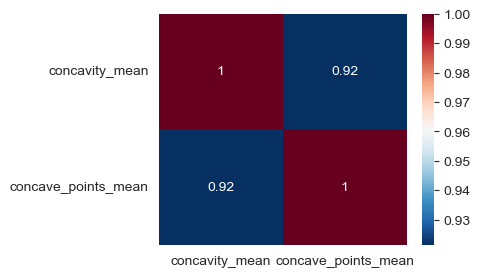

In [28]:
#showing the correlation between concavity_mean and concave_points
CC_mean = df[['concavity_mean','concave_points_mean']]
plt.figure(figsize=(4,3))
sns.heatmap(CC_mean.corr(),annot=True,cmap='RdBu_r');

<font color=blue> Also, a very strong relationship exists between concavity and concave-points as with radius and perimeter

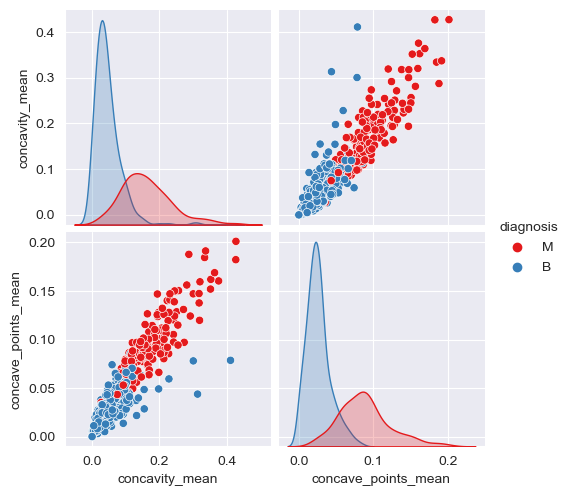

In [29]:
sns.pairplot(df_selection_mean3, hue="diagnosis", palette="Set1");

In [30]:
#getting the min and max values of radius_mean, perimeter_mean, area_mean, and compactness_mean
CC_min=df[['concavity_mean','concave_points_mean']].min()
CC_max=df[['concavity_mean','concave_points_mean']].max()

#putting the min and max values of the radius_mean, perimeter_mean, area_mean, and compactness_mean in a dataframe
CC_minmax =pd.DataFrame([CC_min,CC_max])
CC_minmax

,concavity_mean,concave_points_mean
0,0.0000,0.0000
1,0.4268,0.2012


In [31]:
#replacing the indexes 0 and 1 with min and max
CC_minmax.rename({0:'min',1:'max'}, axis=0, inplace=True)
CC_minmax

,concavity_mean,concave_points_mean
min,0.0000,0.0000
max,0.4268,0.2012


In [32]:
#reversing the row and column axis
CC_minmax = CC_minmax.transpose()
CC_minmax

,min,max
concavity_mean,0.0,0.4268
concave_points_mean,0.0,0.2012


<font color=blue> Here also, the pairplots generally show benign cells as having lower values for both the concavity and concave_points notwithstanding the outliers, which are explained by the worst values.
    
    

    

<font color=blue>
In summary, the distribution of the data depicted first by the histograms showed that most of the features are skewed to the right, meaning that the features generally have more lower values than higher values, and this has been corroborated by the pairplots as benign cells are at the lower end of the spectrum with 357 records while malignant cells, at the higher end of the spectrum, have 212 records.

# Encoding Target Column

It is important to encode the target column as the machine learning models can only interpret numerical data.

In [33]:
df["diagnosis"] = df["diagnosis"].map({"B": 0, "M": 1})
df["diagnosis"].unique()

array([1, 0], dtype=int64)

In [34]:
df["diagnosis"].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

# Split Data

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("diagnosis", axis=1), df["diagnosis"], test_size=0.2, random_state=42
)

print("Shape of training set:", X_train.shape)
print("Shape of test set:", X_test.shape)

Shape of training set: (455, 30)
Shape of test set: (114, 30)


# Build Model Using all Features

In [36]:
#scale data

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

## 1. Logistic Regression

In [37]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
predictions1 = logreg.predict(X_test)

In [38]:
print("Confusion Matrix: \n", confusion_matrix(y_test, predictions1))

Confusion Matrix: 
 [[71  0]
 [ 2 41]]


In [39]:
print("Classification Report: \n", classification_report(y_test, predictions1))

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        71
           1       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [40]:
#check accuracy

logreg_acc = accuracy_score(y_test, predictions1)
print("Accuracy of the Logistic Regression Model is: ", logreg_acc)

Accuracy of the Logistic Regression Model is:  0.9824561403508771


## 2. KNN

Find the optimal error rate

In [41]:
error_rate = []

for i in range(1, 42):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

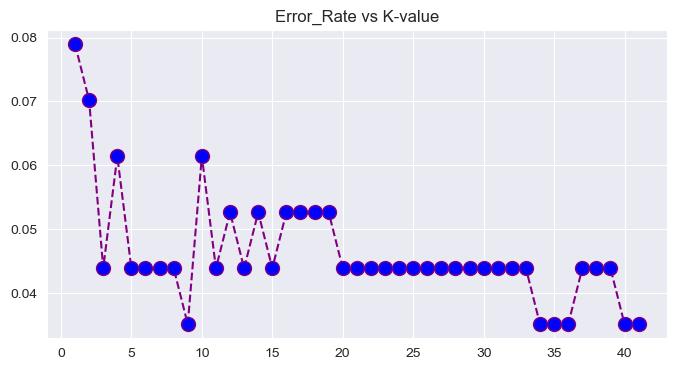

In [42]:
plt.figure(figsize=(8, 4))
plt.plot(
    range(1, 42),
    error_rate,
    color="purple",
    linestyle="--",
    marker="o",
    markersize=10,
    markerfacecolor="b",
)
plt.title("Error_Rate vs K-value")
plt.show()

 From this graph, K value of 9,34,35,36,40 and 41 seem to show the lowest mean error. So using one of these values

In [43]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)
predictions2 = knn.predict(X_test)

In [44]:
confusion_matrix(y_test, predictions2)

array([[69,  2],
       [ 2, 41]], dtype=int64)

In [45]:
classification_report(y_test, predictions2)

'              precision    recall  f1-score   support\n\n           0       0.97      0.97      0.97        71\n           1       0.95      0.95      0.95        43\n\n    accuracy                           0.96       114\n   macro avg       0.96      0.96      0.96       114\nweighted avg       0.96      0.96      0.96       114\n'

In [46]:
#check model accuracy

knn_model_acc = accuracy_score(y_test, predictions2)
print("Accuracy of K Neighbors Classifier Model is: ", knn_model_acc)

Accuracy of K Neighbors Classifier Model is:  0.9649122807017544


## 3. Random Forest

In [47]:
rfc = RandomForestClassifier(n_estimators=300)
rfc.fit(X_train, y_train)
predictions4 = rfc.predict(X_test)

In [48]:
print("Confusion Matrix: \n", confusion_matrix(y_test, predictions4))

Confusion Matrix: 
 [[70  1]
 [ 4 39]]


In [49]:
print("Confusion Matrix: \n", confusion_matrix(y_test, predictions4))
print("\n")
print(classification_report(y_test, predictions4))

Confusion Matrix: 
 [[70  1]
 [ 4 39]]


              precision    recall  f1-score   support

           0       0.95      0.99      0.97        71
           1       0.97      0.91      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [50]:
#check accuracy

rfm_acc = accuracy_score(y_test, predictions4)
print("Accuracy of RFM model is: ", rfm_acc)

Accuracy of RFM model is:  0.956140350877193


## 4. Support Vector Machine

In [51]:
svc_model = SVC(kernel="rbf")
svc_model.fit(X_train, y_train)
predictions5 = svc_model.predict(X_test)

In [52]:
print("Confusion Matrix: \n", confusion_matrix(y_test, predictions5))

Confusion Matrix: 
 [[71  0]
 [ 2 41]]


In [53]:
classification_report(y_test, predictions5)

'              precision    recall  f1-score   support\n\n           0       0.97      1.00      0.99        71\n           1       1.00      0.95      0.98        43\n\n    accuracy                           0.98       114\n   macro avg       0.99      0.98      0.98       114\nweighted avg       0.98      0.98      0.98       114\n'

In [54]:
#check accuracy

svm_acc = accuracy_score(y_test, predictions5)
print("Accuracy of SVM model is: ", svm_acc)

Accuracy of SVM model is:  0.9824561403508771


## Plot to Compare Accuracy of Models

<AxesSubplot:>

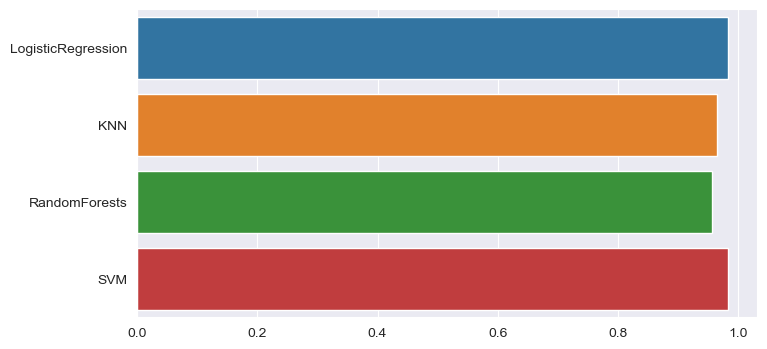

In [55]:
plt.figure(figsize=(8, 4))
model_acc = [logreg_acc, knn_model_acc, rfm_acc, svm_acc]
model_name = ["LogisticRegression", "KNN", "RandomForests", "SVM"]
sns.barplot(x=model_acc, y=model_name)

All the four models selected performed very well when trained with all 30 features with Logistic Regression and SVM having an accuracy of 98.25% 

Next all four models will be trained with the best 10 features to compare performance.

# Build Model with Best 10 Features

## Chi square Feature Selection

In [56]:
X = df.drop("diagnosis", axis=1)
y = df["diagnosis"]

In [57]:
#split Data

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [58]:
#apply SelectKBest class to extract top 10 best features

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_train,y_train)

In [59]:
#create a dataframe that shows each feature and its corresponding chi2 score

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

feature_scores = pd.concat([dfcolumns, dfscores], axis=1)
feature_scores.columns = ["Feature", "Score"]

feature_scores = feature_scores.sort_values("Score", ascending=False).reset_index(
    drop=True
)
feature_scores

,Feature,Score
0,area_worst,92574.107701
1,area_mean,44301.419325
2,area_se,7337.838986
3,perimeter_worst,3013.196990
4,perimeter_mean,1647.177721
5,radius_worst,403.262787
6,radius_mean,217.672175
7,perimeter_se,210.120610
8,texture_worst,141.067689
9,texture_mean,73.630059


<BarContainer object of 10 artists>

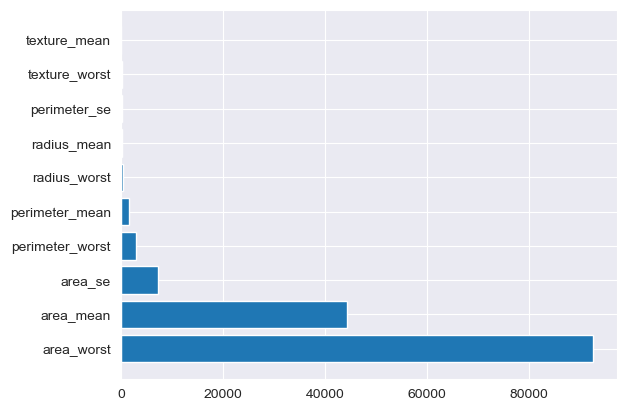

In [60]:
#plot 10 best features

df_chi2 = feature_scores.nlargest(10, "Score")
plt.barh(y=df_chi2.Feature, width=df_chi2.Score)

## Extra Trees Classifier

In [61]:
model_etc = ExtraTreesClassifier(random_state=42)
model_etc.fit(X_train, y_train)

ExtraTreesClassifier(random_state=42)

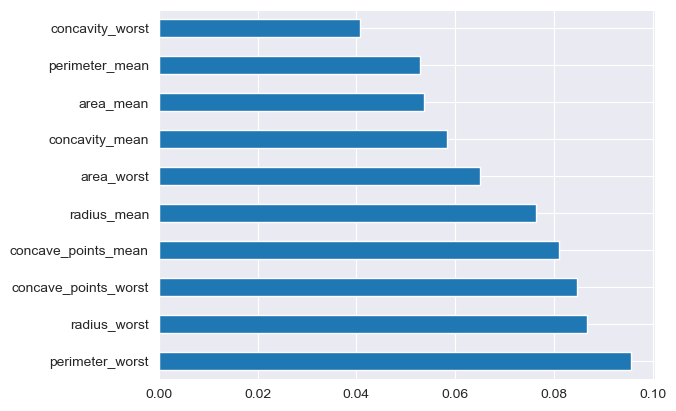

In [62]:
#plot graph of feature importances for better visualization

feat_importances = pd.Series(model_etc.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind="barh")
plt.show()

In [63]:
#let's create a featue selection list which is the intersection of the top 15 features from chi2 test and extratreesclassifier

#create the top 15 list for chi2
df_fi = (
    (pd.DataFrame(feat_importances.sort_values(ascending=False))).head(15).reset_index()
)
df_fi.columns = ["Feature", "Importance_Score"]
chi2_list = list(df_fi.Feature)

#create the top 15 list for extratreesclassifier
etc_list = list(feature_scores.head(15).Feature)

#create feature selection list
feature_selection = []
for i in etc_list:
    if i in chi2_list:
        feature_selection.append(i)
print(feature_selection)
print(len(feature_selection))

['area_worst', 'area_mean', 'area_se', 'perimeter_worst', 'perimeter_mean', 'radius_worst', 'radius_mean', 'perimeter_se', 'concavity_worst', 'radius_se', 'concavity_mean', 'compactness_worst', 'concave_points_worst']
13


In [64]:
#reduce the features according to its importance

X_train = X_train[feature_selection]
X_test = X_test[feature_selection]

In [65]:
#scale data

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Cross Validation to select Best Model

## 1. Logistic Regression

In [66]:
clf_lr = LogisticRegression()
score = cross_val_score(clf_lr, X_train, y_train, cv=5, scoring="accuracy").mean()
score

0.9362637362637363

## 2. KNN

In [67]:
clf_kn = KNeighborsClassifier()
score = cross_val_score(clf_kn, X_train, y_train, cv=5, scoring="accuracy").mean()
score

0.945054945054945

## 3. Random Forest

In [68]:
clf_rf = RandomForestClassifier()
score = cross_val_score(clf_rf, X_train, y_train, cv=5, scoring="accuracy").mean()
score

0.934065934065934

## 4. SVM

In [69]:
svc_model = SVC(kernel="rbf")
score = cross_val_score(svc_model, X_train, y_train, cv=5, scoring="accuracy").mean()
score

0.9428571428571428

The model selected is the Random Forest as it has the best accuracy based on it's cross validation score.

## Fit Data to Best Model

In [70]:
model =RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [71]:
confusion_matrix(y_test, y_pred)

array([[72,  0],
       [ 4, 38]], dtype=int64)

In [72]:
# print the classification report
classification_report(y_pred, y_test)

'              precision    recall  f1-score   support\n\n           0       1.00      0.95      0.97        76\n           1       0.90      1.00      0.95        38\n\n    accuracy                           0.96       114\n   macro avg       0.95      0.97      0.96       114\nweighted avg       0.97      0.96      0.97       114\n'

In [73]:
#check accuracy

rf_acc = accuracy_score(y_test, y_pred)
print("Accuracy of RF model is: ", rf_acc)

Accuracy of RF model is:  0.9649122807017544


When trained with best 10 features, our model accuracy dropped to 96.50%.

# Observations 

It is better to use all features for training than limit the training to only the best 10 features.

Some possible reasons using the best 10 features led to a reduction in performance include but not limited to:

* The top ten features may not have been the most informative or relevant features for the task at hand.
* The features are highly correlated with each other, which could have led to overfitting or poor generalization.
* The feature selection method might have been biased or poorly chosen.
* The data set could be small and not representative of the entire population, causing overfitting or poor generalization.

# Conclusion

In conclusion, the goal of this project was to develop a Machine Learning Model with a high accuracy and precision and Logistic Regression and SVM have both achieved an accuracy of 98.2%. 

This high level of accuracy indicates that the model has the ability to effectively identify the type of cancer in an individual, with a low rate of false positives and false negatives.

However, it is important to note that this model should be further validated using a larger and more diverse dataset to ensure its performance in a real-world scenario. 